In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("ProductRecommendation").getOrCreate()

# Load the dataset
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/ratings_Beauty.csv", header=True, inferSchema=True)

# Show the schema and first few rows
df.printSchema()
num_rows = df.count()

# Print the result
print(f"Number of rows in the dataset: {num_rows}")
df.show(5)

root
 |-- UserId: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Timestamp: integer (nullable = true)

Number of rows in the dataset: 2023070
+--------------+----------+------+----------+
|        UserId| ProductId|Rating| Timestamp|
+--------------+----------+------+----------+
|A39HTATAQ9V7YF|0205616461|   5.0|1369699200|
|A3JM6GV9MNOF9X|0558925278|   3.0|1355443200|
|A1Z513UWSAAO0F|0558925278|   5.0|1404691200|
|A1WMRR494NWEWV|0733001998|   4.0|1382572800|
|A3IAAVS479H7M7|0737104473|   1.0|1274227200|
+--------------+----------+------+----------+
only showing top 5 rows



In [3]:
from pyspark.sql.functions import col, sum

# Check for missing values in each column
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------+---------+------+---------+
|UserId|ProductId|Rating|Timestamp|
+------+---------+------+---------+
|     0|        0|     0|        0|
+------+---------+------+---------+



In [4]:
# Drop duplicate rows
df = df.dropDuplicates()
df.select("Rating").describe().show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|           2023070|
|   mean| 4.149035871225415|
| stddev|1.3115045737121391|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



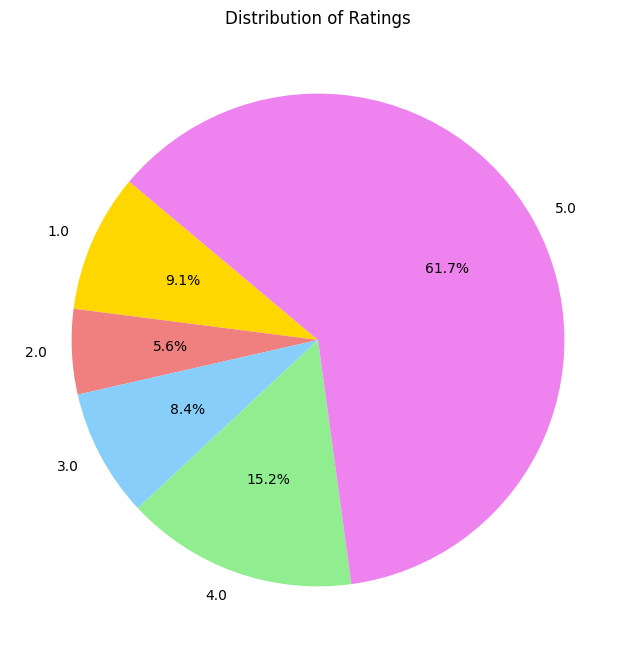

In [ ]:
from pyspark.sql import functions as F

# Group by Rating and count the occurrences
rating_distribution = df.groupBy("Rating").agg(F.count("Rating").alias("count")).orderBy("Rating")

# Convert to Pandas for visualization
rating_distribution_pd = rating_distribution.toPandas()
import matplotlib.pyplot as plt

# Extract labels and sizes for the pie chart
labels = rating_distribution_pd["Rating"].astype(str)  # Rating values as labels
sizes = rating_distribution_pd["count"]  # Count of each rating

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=["gold", "lightcoral", "lightskyblue", "lightgreen", "violet"])
plt.title("Distribution of Ratings")
plt.show()

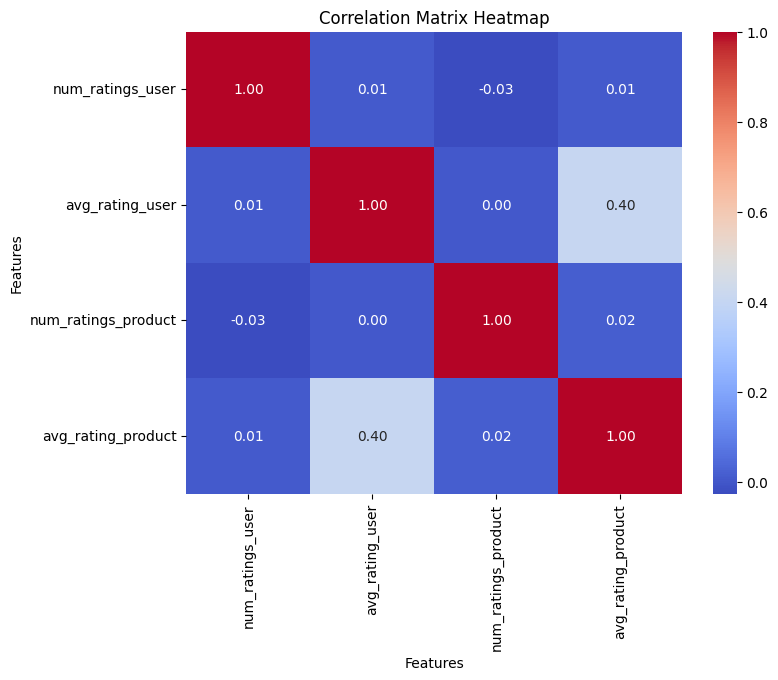

In [5]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt


# Feature engineering
user_activity = df.groupBy("UserId").agg(
    F.count("Rating").alias("num_ratings_user"),
    F.avg("Rating").alias("avg_rating_user")
)

product_popularity = df.groupBy("ProductId").agg(
    F.count("Rating").alias("num_ratings_product"),
    F.avg("Rating").alias("avg_rating_product")
)

df = df.join(user_activity, on="UserId", how="left")
df = df.join(product_popularity, on="ProductId", how="left")

# Select numerical features
numerical_df = df.select(
    "num_ratings_user",
    "avg_rating_user",
    "num_ratings_product",
    "avg_rating_product"
)

# Assemble numerical features into a vector column
assembler = VectorAssembler(inputCols=numerical_df.columns, outputCol="features")
vector_df = assembler.transform(numerical_df).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(vector_df, "features").collect()[0][0]
correlation_matrix = correlation_matrix.toArray()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=numerical_df.columns,
    yticklabels=numerical_df.columns
)

plt.title("Correlation Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

<ipython-input-6-7ee033b95aa0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="ProductId", data=top_products, palette="viridis")


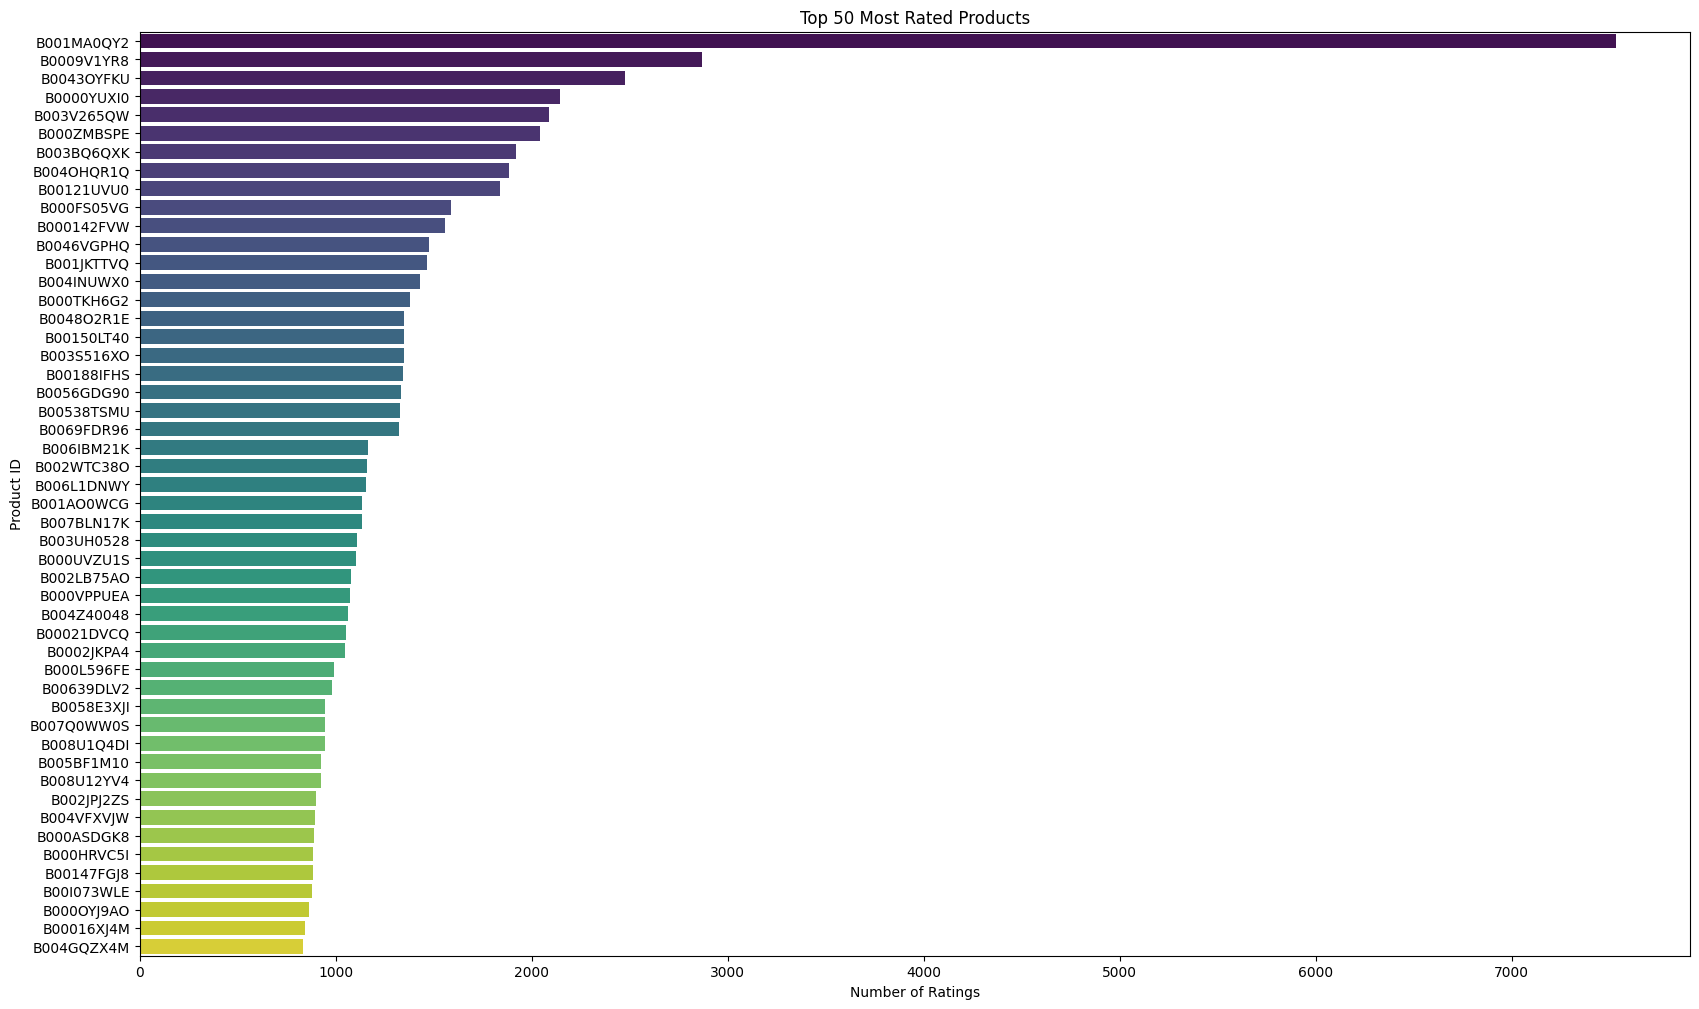

In [6]:
# Group by ProductId, count ratings, and sort in descending order
top_products = df.groupBy("ProductId").count().orderBy("count", ascending=False).limit(50).toPandas()

# Plot the top 10 most rated products
plt.figure(figsize=(20, 12))
sns.barplot(x="count", y="ProductId", data=top_products, palette="viridis")
plt.title("Top 50 Most Rated Products")
plt.xlabel("Number of Ratings")
plt.ylabel("Product ID")
plt.show()

<ipython-input-7-ae79c5990bb3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="UserId", data=top_users, palette="magma")


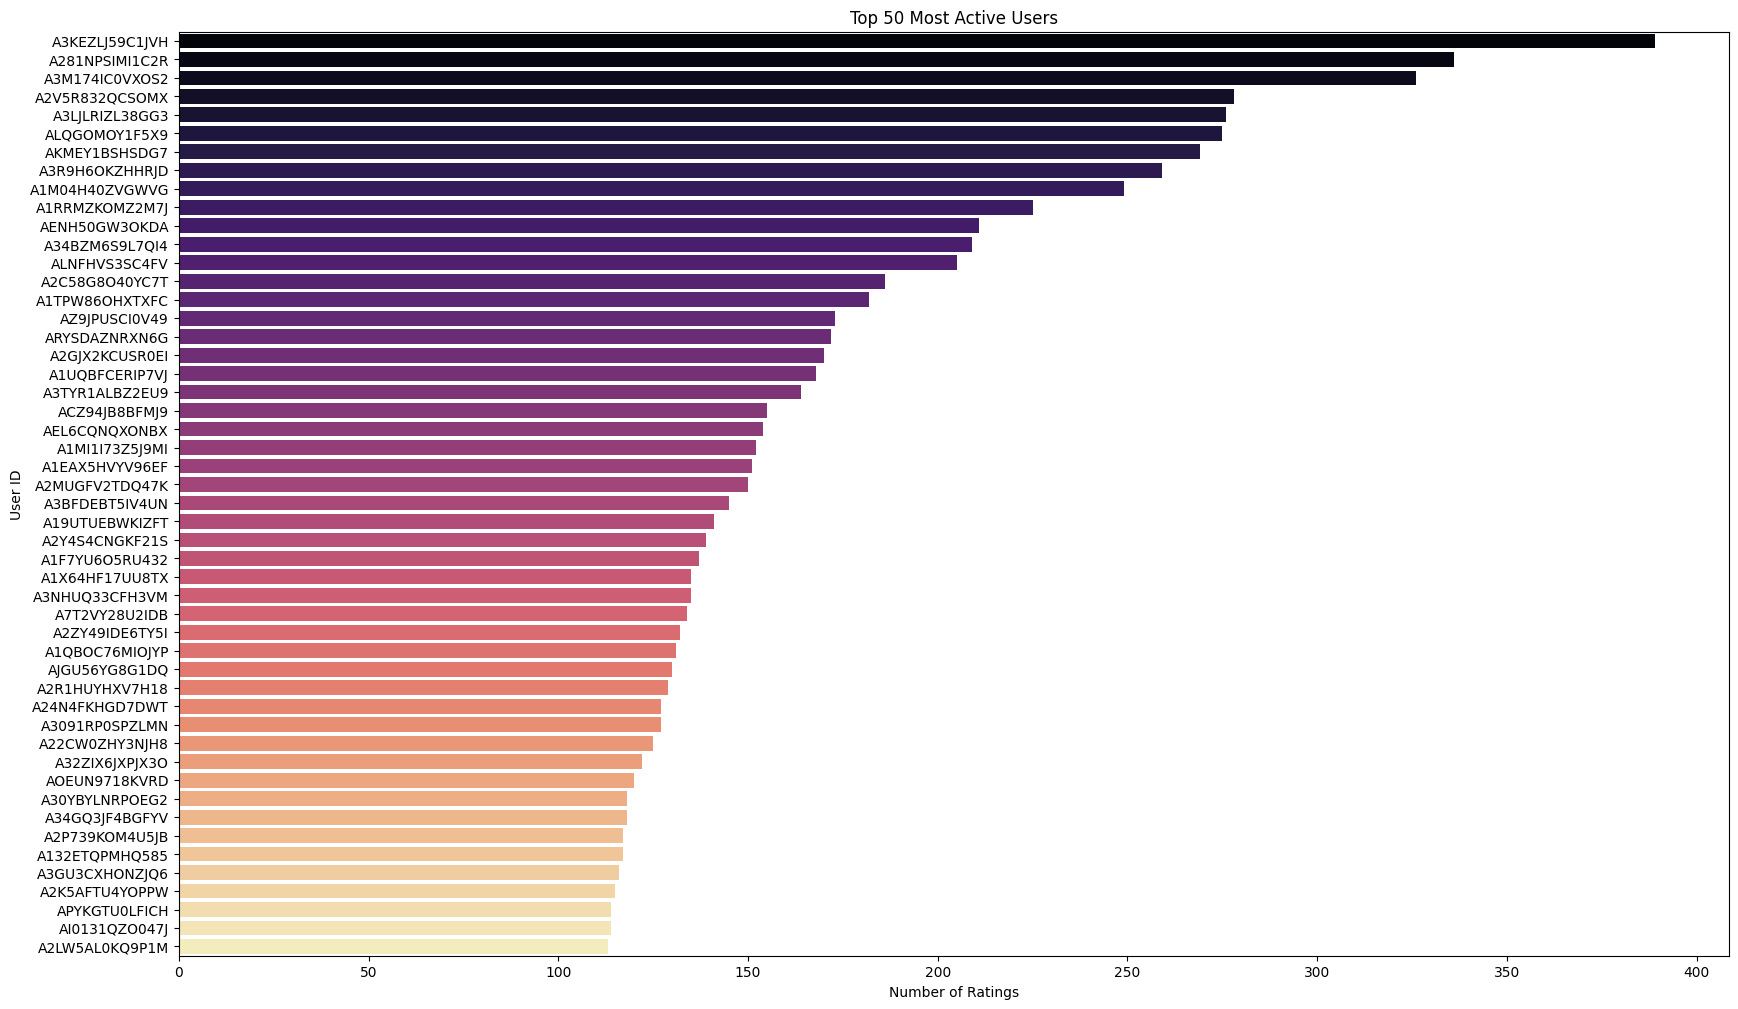

In [7]:
# Group by UserId, count ratings, and sort in descending order
top_users = df.groupBy("UserId").count().orderBy("count", ascending=False).limit(50).toPandas()

# Plot the top 10 most active users
plt.figure(figsize=(20, 12))
sns.barplot(x="count", y="UserId", data=top_users, palette="magma")
plt.title("Top 50 Most Active Users")
plt.xlabel("Number of Ratings")
plt.ylabel("User ID")
plt.show()

In [ ]:
# Filter users with at least 5 ratings
user_counts = df.groupBy("UserId").count()
df = df.join(user_counts, on="UserId").filter(col("count") >= 5).drop("count")

# Filter products with at least 5 ratings
product_counts = df.groupBy("ProductId").count()
df = df.join(product_counts, on="ProductId").filter(col("count") >= 5).drop("count")

In [ ]:
# Save the preprocessed data
df.write.csv("preprocessed_rating_beauty.csv", header=True)

In [ ]:
filtered_df = spark.read.csv("preprocessed_rating_beauty.csv", header=True, inferSchema=True)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "/content/Book1.xlsx"
ratings = pd.read_excel(file_path)

# Train-test split (70-30)
X_train, X_test = train_test_split(ratings, test_size=0.30, random_state=42)

# Create copies of train and test datasets
dummy_train = X_train.copy()
dummy_test = X_test.copy()

# Modify ratings:
# - In `dummy_train`: Rated items (rating > 0) are set to `0`, unrated ones to `1`
# - In `dummy_test`: Rated items (rating > 0) are set to `1`, unrated ones to `0`
dummy_train['Rating'] = dummy_train['Rating'].apply(lambda x: 0 if x > 0 else 1)
dummy_test['Rating'] = dummy_test['Rating'].apply(lambda x: 1 if x > 0 else 0)

# Pivot the datasets to create user-product matrices
dummy_train = dummy_train.pivot(index='UserId', columns='ProductId', values='Rating').fillna(1)
dummy_test = dummy_test.pivot(index='UserId', columns='ProductId', values='Rating').fillna(0)

# Display first few rows
print(dummy_train.head())
print(dummy_test.head())


ProductId              558925278  737104473  762451459  1304139212  \
UserId                                                               
A00205921JHJK5X9LNP42        1.0        1.0        1.0         1.0   
A00473363TJ8YSZ3YAGG9        1.0        1.0        1.0         1.0   
A024581134CV80ZBLIZTZ        1.0        1.0        1.0         1.0   
A0505229A7NSH3FRXRR4         1.0        1.0        1.0         1.0   
A05492663T95KW63BR75K        1.0        1.0        1.0         1.0   

ProductId              1304139220  1304168522  1304174778  1304174867  \
UserId                                                                  
A00205921JHJK5X9LNP42         1.0         1.0         1.0         1.0   
A00473363TJ8YSZ3YAGG9         1.0         1.0         1.0         1.0   
A024581134CV80ZBLIZTZ         1.0         1.0         1.0         1.0   
A0505229A7NSH3FRXRR4          1.0         1.0         1.0         1.0   
A05492663T95KW63BR75K         1.0         1.0         1.0         1.0  

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute User Similarity Matrix using Cosine similarity
user_similarity = cosine_similarity(dummy_train)
user_similarity[np.isnan(user_similarity)] = 0  # Handle NaN values
print(user_similarity)
print(user_similarity.shape)

# Predict Ratings using similarity-weighted sum
user_predicted_ratings = np.dot(user_similarity, dummy_train)
print(user_predicted_ratings)

# Multiply by dummy_train to remove already rated products
user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
print(user_final_ratings.head())

# Recommend top 5 products for a specific user
print(user_final_ratings.iloc[42].sort_values(ascending=False)[0:5])

[[1.        0.9987715 0.9987715 ... 0.9981563 0.9987715 0.9987715]
 [0.9987715 1.        0.9987715 ... 0.9981563 0.9987715 0.9987715]
 [0.9987715 0.9987715 1.        ... 0.9981563 0.9987715 0.9987715]
 ...
 [0.9981563 0.9981563 0.9981563 ... 1.        0.9981563 0.9981563]
 [0.9987715 0.9987715 0.9987715 ... 0.9981563 1.        0.9987715]
 [0.9987715 0.9987715 0.9987715 ... 0.9981563 0.9987715 1.       ]]
(7783, 7783)
[[7771.35358685 7772.35235835 7772.35235835 ... 7772.35235835
  7772.35235835 7772.35235835]
 [7771.35727386 7772.35604536 7772.35604536 ... 7772.35604536
  7772.35604536 7772.35604536]
 [7771.32164581 7772.32041731 7772.32041731 ... 7772.32041731
  7772.32041731 7772.32041731]
 ...
 [7766.58007907 7767.57823537 7767.57823537 ... 7767.57823537
  7767.57823537 7767.57823537]
 [7771.47766849 7772.47643999 7772.47643999 ... 7772.47643999
  7772.47643999 7772.47643999]
 [7771.53295408 7772.53172558 7772.53172558 ... 7772.53172558
  7772.53172558 7772.53172558]]
ProductId      

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute Item Similarity Matrix using Cosine Similarity
# Transpose dummy_train for item-based similarity
item_similarity = cosine_similarity(dummy_train.T)
item_similarity[np.isnan(item_similarity)] = 0  # Handle NaN values
print(item_similarity)
print(item_similarity.shape)

# Predict Ratings using similarity-weighted sum
item_predicted_ratings = np.dot(dummy_train, item_similarity)
print(item_predicted_ratings)

# Multiply by dummy_train to remove already rated products
item_final_ratings = np.multiply(item_predicted_ratings, dummy_train)
print(item_final_ratings.head())

# Recommend top 5 products for a specific user (Example: User ID 42)
print(item_final_ratings.iloc[42].sort_values(ascending=False)[0:5])

[[1.         0.99980724 0.99980724 ... 0.99980724 0.99980724 0.99980724]
 [0.99980724 1.         0.9998715  ... 0.9998715  0.9998715  0.9998715 ]
 [0.99980724 0.9998715  1.         ... 0.9998715  0.9998715  0.9998715 ]
 ...
 [0.99980724 0.9998715  0.9998715  ... 1.         0.9998715  0.9998715 ]
 [0.99980724 0.9998715  0.9998715  ... 0.9998715  1.         0.9998715 ]
 [0.99980724 0.9998715  0.9998715  ... 0.9998715  0.9998715  1.        ]]
(815, 815)
[[813.38288096 813.43515017 813.43515017 ... 813.43515017 813.43515017
  813.43515017]
 [813.38307413 813.4353433  813.4353433  ... 813.4353433  813.4353433
  813.4353433 ]
 [813.3812084  813.43347793 813.43347793 ... 813.43347793 813.43347793
  813.43347793]
 ...
 [812.38371748 812.4359223  812.4359223  ... 812.4359223  812.4359223
  812.4359223 ]
 [813.389405   813.44167295 813.44167295 ... 813.44167295 813.44167295
  813.44167295]
 [813.39232561 813.44459299 813.44459299 ... 813.44459299 813.44459299
  813.44459299]]
ProductId          

In [12]:
from sklearn.preprocessing import MinMaxScaler

test_user_features = X_test.pivot(index='UserId', columns='ProductId', values='Rating').fillna(0)
test_user_similarity = cosine_similarity(test_user_features)
test_user_similarity[np.isnan(test_user_similarity)] = 0

print(test_user_similarity)
print("- "*10)
print(test_user_similarity.shape)
user_predicted_ratings_test = np.dot(test_user_similarity, test_user_features)
user_predicted_ratings_test
test_user_final_rating = np.multiply(user_predicted_ratings_test, dummy_test)
test_user_final_rating.head()
from sklearn.preprocessing import MinMaxScaler

X = test_user_final_rating.copy()
X = X[X > 0] # only consider non-zero values as 0 means the user haven't rated the movies

# Convert column names to strings before fitting
X.columns = X.columns.astype(str)

scaler = MinMaxScaler(feature_range = (0.5, 5))
scaler.fit(X)
pred = scaler.transform(X)

print(pred)
# RMSE Score

# Replace 'test' with 'test_user_features' to calculate the difference
diff_sqr_matrix = (test_user_features - pred)**2
sum_of_squares_err = diff_sqr_matrix.sum().sum() # df.sum().sum() by default ignores null values

# You might need to define or calculate total_non_nan
total_non_nan = np.count_nonzero(~np.isnan(diff_sqr_matrix))
rmse = np.sqrt(sum_of_squares_err/total_non_nan)
print(rmse)

# Replace 'test' with 'test_user_features' for MAE calculation
mae = np.abs(pred - test_user_features).sum().sum()/total_non_nan
print(mae)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 1.]]
- - - - - - - - - - 
(3382, 3382)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
3.4043221629081724
2.8305720655490663


In [18]:
test_item_features = X_test.pivot(index='UserId', columns='ProductId', values='Rating').fillna(0)
test_item_similarity = cosine_similarity(test_item_features)
test_item_similarity[np.isnan(test_item_similarity)] = 0

print(test_item_similarity)
print("- "*10)
print(test_item_similarity.shape)
item_predicted_ratings_test = np.dot(test_item_features.T, test_item_similarity )
item_predicted_ratings_test
test_item_final_rating = np.multiply(item_predicted_ratings_test.T, dummy_test)
test_item_final_rating.head()
ratings['Rating'].describe()
from sklearn.preprocessing import MinMaxScaler

X = test_item_final_rating.copy()
X = X[X > 0] # only consider non-zero values as 0 means the user haven't rated the movies

X.columns = X.columns.astype(str)

scaler = MinMaxScaler(feature_range = (0.5, 5))
scaler.fit(X)
pred = scaler.transform(X)

print(pred)

test = X_test.pivot(index = 'UserId', columns = 'ProductId', values = 'Rating') # Use 'UserId' and 'ProductId'
test.head()

# RMSE Score

diff_sqr_matrix = (test - pred)**2
sum_of_squares_err = diff_sqr_matrix.sum().sum() # df.sum().sum() by default ignores null values

rmse = np.sqrt(sum_of_squares_err/total_non_nan)
print(rmse)

mae = np.abs(pred - test).sum().sum()/total_non_nan
print(mae)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 1.]]
- - - - - - - - - - 
(3382, 3382)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
3.4043221629081724
2.8305720655490663


In [27]:
!pip install openpyxl
!pip install pyspark --upgrade --quiet
!pip install spark.excel

ERROR: Could not find a version that satisfies the requirement spark.excel (from versions: none)
ERROR: No matching distribution found for spark.excel


In [36]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, lit, when, count, isnan, sum as spark_sum
from pyspark.mllib.linalg.distributed import IndexedRowMatrix, IndexedRow
from pyspark.mllib.linalg import Vectors as MLLibVectors  # Note: Using MLlib Vectors
import numpy as np
from pyspark.sql.types import FloatType
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors as MLVectors  # ML library vectors

# Initialize Spark session
spark = SparkSession.builder \
    .appName("CollaborativeFiltering") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.7") \
    .getOrCreate()


import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Read with pandas first
pdf = pd.read_excel("/content/Book1.xlsx")

# Convert to Spark DataFrame
ratings = spark.createDataFrame(pdf)

# Convert rating column to float if needed
ratings = ratings.withColumn("Rating", col("Rating").cast(FloatType()))

# Train-test split (70-30)
train, test = ratings.randomSplit([0.7, 0.3], seed=42)

# Create dummy train and test sets
dummy_train = train.withColumn("Rating",
    when(col("Rating") > 0, lit(0)).otherwise(lit(1)))
dummy_test = test.withColumn("Rating",
    when(col("Rating") > 0, lit(1)).otherwise(lit(0)))

# Pivot the datasets to create user-product matrices
def create_pivot(df):
    return df.groupBy("UserId").pivot("ProductId").agg(spark_sum("Rating")).fillna(0)

dummy_train_pivot = create_pivot(dummy_train)
dummy_test_pivot = create_pivot(dummy_test)
train_pivot = create_pivot(train)
test_pivot = create_pivot(test)

# Corrected function to convert DataFrame to IndexedRowMatrix
def df_to_indexed_row_matrix(df, index_col):
    # Get all column names except the index column
    feature_cols = [c for c in df.columns if c != index_col]

    # Create mapping from index values to sequential indices
    index_values = df.select(index_col).distinct().rdd.flatMap(lambda x: x).collect()
    index_map = {v: i for i, v in enumerate(index_values)}

    # Convert to IndexedRowMatrix
    indexed_rows = df.rdd.map(lambda row:
        IndexedRow(
            index_map[row[index_col]],  # Use mapped index
            MLLibVectors.dense([float(row[c]) for c in feature_cols])  # Use MLlib Vectors
        )
    )
    return IndexedRowMatrix(indexed_rows)

In [37]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry
from pyspark.mllib.linalg import Vectors as MLLibVectors

# User-based collaborative filtering (unchanged)
user_matrix = df_to_indexed_row_matrix(dummy_train_pivot, "UserId")
user_similarity = user_matrix.columnSimilarities()
print("User similarity matrix:")
print(user_similarity.entries.take(5))

User similarity matrix:
[]


In [38]:
# Item-based collaborative filtering - corrected approach
def create_item_similarity_matrix(df, index_col):
    # Get all column names except the index column
    feature_cols = [c for c in df.columns if c != index_col]

    # Create item vectors (transposed perspective)
    item_vectors = []
    for item_col in feature_cols:
        # Collect all user ratings for this item
        ratings = df.select(index_col, item_col).rdd \
            .map(lambda row: (row[index_col], float(row[item_col]))) \
            .collect()

        # Create vector for this item
        vector = MLLibVectors.sparse(
            len(df.select(index_col).distinct().collect()),  # dimension
            [(idx, rating) for (idx, rating) in ratings if rating != 0]
        )
        item_vectors.append(vector)

    # Create IndexedRowMatrix for items
    indexed_rows = spark.sparkContext.parallelize(
        [(i, vec) for i, vec in enumerate(item_vectors)]
    ).map(lambda x: IndexedRow(x[0], x[1]))

    return IndexedRowMatrix(indexed_rows)

# Create item similarity matrix
item_matrix = create_item_similarity_matrix(dummy_train_pivot, "UserId")
item_similarity = item_matrix.columnSimilarities()
print("\nItem similarity matrix:")
print(item_similarity.entries.take(5))


Item similarity matrix:
[]


In [ ]:
# Alternative approach using CoordinateMatrix if the above doesn't work
def create_coordinate_matrix(df, index_col):
    entries = []
    feature_cols = [c for c in df.columns if c != index_col]

    # Create mapping from user IDs to indices
    user_ids = df.select(index_col).distinct().rdd.flatMap(lambda x: x).collect()
    user_idx_map = {user_id: idx for idx, user_id in enumerate(user_ids)}

    # Create mapping from item IDs to indices
    item_idx_map = {item_id: idx for idx, item_id in enumerate(feature_cols)}

    # Create matrix entries
    for row in df.collect():
        user_id = row[index_col]
        user_idx = user_idx_map[user_id]
        for item_col in feature_cols:
            item_idx = item_idx_map[item_col]
            rating = float(row[item_col])
            if rating != 0:
                entries.append(MatrixEntry(user_idx, item_idx, rating))

    # Create CoordinateMatrix
    return CoordinateMatrix(
        spark.sparkContext.parallelize(entries)
    )

# Create and transpose the matrix
coordinate_matrix = create_coordinate_matrix(dummy_train_pivot, "UserId")
item_matrix = coordinate_matrix.transpose().toIndexedRowMatrix()
item_similarity = item_matrix.columnSimilarities()
print("\nAlternative Item similarity matrix:")
print(item_similarity.entries.take(5))

In [44]:
# ALS implementation (alternative approach)
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import monotonically_increasing_id, row_number,abs as pyspark_abs
from pyspark.sql.window import Window

# Add a unique numeric ID for users within a limited range
w = Window().orderBy("UserId")  # Define a window for ordering
train = train.withColumn("user_id_num", row_number().over(w).cast(IntegerType()))
test = test.withColumn("user_id_num", row_number().over(w).cast(IntegerType()))

# Similarly, add a unique numeric ID for Products within a limited range
w = Window().orderBy("ProductId")  # Define a window for ordering
train = train.withColumn("product_id_num", row_number().over(w).cast(IntegerType()))
test = test.withColumn("product_id_num", row_number().over(w).cast(IntegerType()))

als = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="user_id_num", # Changed to numeric user ID column
    itemCol="product_id_num", # Changed to numeric product ID column
    ratingCol="Rating",
    coldStartStrategy="drop"
)
model = als.fit(train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# MAE calculation
predictions = predictions.withColumn("abs_error", pyspark_abs(col("prediction") - col("Rating")))
mae = predictions.agg({"abs_error": "avg"}).collect()[0][0]
print(f"Mean Absolute Error = {mae}")


# Generate top 5 recommendations for each user
userRecs = model.recommendForAllUsers(5)
print("\nTop 5 recommendations for some users:")
userRecs.show(5)

# Generate top 5 recommendations for each product
productRecs = model.recommendForAllItems(5)
print("\nTop 5 recommendations for some products:")
productRecs.show(5)

# Stop Spark session
spark.stop()

Root-mean-square error = 4.648624992685122
Mean Absolute Error = 4.294618343316525

Top 5 recommendations for some users:
+-----------+--------------------+
|user_id_num|     recommendations|
+-----------+--------------------+
|          1|[{248, 4.9978075}...|
|          3|[{2256, 4.997807}...|
|          5|[{6545, 4.4131017...|
|          6|[{5136, 4.9978075...|
|          9|[{7284, 4.997807}...|
+-----------+--------------------+
only showing top 5 rows


Top 5 recommendations for some products:
+--------------+--------------------+
|product_id_num|     recommendations|
+--------------+--------------------+
|             1|[{2332, 4.997807}...|
|             3|[{7840, 4.9978065...|
|             5|[{6335, 4.997807}...|
|             6|[{7841, 4.997807}...|
|             9|[{664, 4.997807},...|
+--------------+--------------------+
only showing top 5 rows

